<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <img src="images/Xlogo.png" alt="Transposition of a vector" title="Vector transposition" width="115" style="float: left;">
  <p style=" text-align: center; font-size: 32px;">   
   <strong> Fractional and Volterra processes in Finance  </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Challenge 2 -  Pricing by Fourier </strong></p>
  <p style=" text-align: center; font-size: 20px;"> Eduardo Abi Jaber </p>
</header>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 

# <font color='red'>PLEASE ENTER YOUR FULL NAMES HERE:</font>

- Dimitri Sotnikov
- Elie Jabbour
- Romain Farthoat

<font color='red'>**DEADLINE: March 10 before 10 AM to be sent by email to eduardo.abi-jaber@polytechnique.edu**</font>

 <font color='red'>**Please send both pdf ipynb files with name : GroupX_Challenge2**
</font>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">1. Heston</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 

1. Implement the characteristic function of the conventional Heston model
\begin{align*}
	dS_t &=S_t \sqrt{V_t} dB_t, \quad d\langle W, B\rangle_t = \rho dt \\
	dV_t &= (\theta-\kappa V_t)dt + \eta \sqrt{V_t} dW_t, \quad V_0 \geq 0, S_0=1
\end{align*}
    
Denote by 
$$ \Phi_{T}(z) = \mathbb E\left[ \exp\left( \mathrm i z \log S_T \right) \right]$$

2. Price Put options pricer using  Lewis inversion formula
$$ \mathbb E (K-S_T)^+ = K - \frac {\sqrt{S_0K}}{\pi } \int_{\mathbb R_+} \Re \left(e^{izk} \frac{\Phi_T(z-\frac{i}{2})}{z^2 + \frac 1 4 }\right) dz,$$
with $k=\log(S_0/K)$.

3. Plot implied vol surface (slice by slice for different maturity slices $T$ ranging from 0.02 to 1)

4. Set $\kappa=\eta=1/\epsilon$ and plot the atm skew as $\epsilon \to 0$ and comment.  


Calls are obtained by Put call parity (r=0).


To sanity check your code here are two value of references for prices of call.

Recall: 



<div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);"> 
    <strong>Theorem</strong>. (Characteristic function in Heston model)  For $v\in \mathbb R$, 
$$
\mathbb E[\exp\left(iv\log S_T \right) |\mathcal F_t]  = \exp\left( iv\log S_t + \phi(T-t)  + \psi(T-t) V_t \right),
$$
with 
\begin{align*}
\psi(t)&= \frac{\beta(v)-D(v)}{\eta^2}\frac{1-e^{-D(v)t}}{1-G(v)e^{-D(v)t}}\\
\phi(t)&= \frac{\theta}{\eta^2}\left((\beta(v)-D(v))t - 2 \log\left( \frac{G(v)e^{-D(v)t}-1}{G(v)-1} \right)\right)  \\
\beta(v) &= \kappa - iv \rho\eta, \quad  D(v)= \sqrt{\beta(v)^2  + \eta^2 v(i+v)}, \quad G(v) =\frac{\beta(v)-D(v)}{\beta(v)+ D(v)}.
\end{align*}
</div>
   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from scipy.stats import norm
from scipy.special import gamma
from dataclasses import dataclass
from abc import abstractmethod, ABC
from math import ceil
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
class CF_model(ABC): 
    """
    An abstract class to price options in the models with the characteristic function available.
    """
    @abstractmethod
    def _charfunc(self, v, T, St, Vt, t = 0):
        raise NotImplementedError()
    
    def put(self, T, K, S, V):
        k = np.log(S / K)
        integrand = lambda z: (np.exp(1j * z * k) * self._charfunc(z - 1j / 2, T, S, V) / (z**2 + 0.25)).real
        result = integrate.quad(integrand, 0, np.inf)
        return K - np.sqrt(S * K) / np.pi * result[0]
    
    def call(self, T, K, S, V):
        return S - K + self.put(T, K, S, V)

In [4]:
@dataclass
class Heston_model(CF_model):
    theta: float
    kappa: float
    eta: float
    rho: float
    
    def __repr__(self):
        return repr(f"Heston model with the following parameters : theta = {self.theta}, kappa = {self.kappa}, eta = {self.eta}, rho = {self.rho}")

    def __B(self, v):
        return self.kappa - 1j * v * self.rho * self.eta

    def __D(self, v):
        return np.sqrt( self.__B(v)**2 + self.eta**2 * v * (1j + v) )

    def __G(self, v):
        return (self.__B(v) - self.__D(v)) / (self.__B(v) + self.__D(v))

    def __phi(self, v, t):
        return self.theta / self.eta**2 * ( (self.__B(v) - self.__D(v)) * t - 2 * np.log( (self.__G(v) * np.exp(-self.__D(v) * t) - 1) / (self.__G(v) - 1) ) )

    def __psi(self, v, t):
        return (self.__B(v) - self.__D(v)) / self.eta**2 * ( 1 - np.exp(-self.__D(v) * t) ) / ( 1 - self.__G(v) * np.exp(-self.__D(v) * t) )

    def _charfunc(self, v, T, St, Vt, t=0):
        if t is None:
            t = 0
        return np.exp(1j * v * np.log(St) + self.__phi(v, T-t) + self.__psi(v, T-t) * Vt)

In [5]:
kappa = 1.5768
theta = 0.0398*1.5768
rho = -0.5711
eta = 0.5751

S0 = 1.
V0 = 0.0175
r=0.
K = 1.

ref_value_T1y = 0.05785155435  #See fang osterlee p15
ref_value_T10y = 0.22318945791474590  #See fang osterlee p15 

X_hest = Heston_model(theta=theta, kappa=kappa, eta=eta, rho=rho)
X_hest

'Heston model with the following parameters : theta = 0.06275664, kappa = 1.5768, eta = 0.5751, rho = -0.5711'

In [6]:
print("T = One year")
print("Reference price: ", ref_value_T1y)
print("Our model price: ", X_hest.call(1, K, S0, V0))
print("Diff", ref_value_T1y - X_hest.call(1, K, S0, V0))

print("\n\nT = Ten years")
print("Reference price: ", ref_value_T10y)
print("Our model price: ", X_hest.call(10, K, S0, V0))
print("Diff", ref_value_T10y - X_hest.call(10, K, S0, V0))

T = One year
Reference price:  0.05785155435
Our model price:  0.057851554343202105
Diff 6.7978955797798335e-12


T = Ten years
Reference price:  0.2231894579147459
Our model price:  0.2231894579115471
Diff 3.1988023341256167e-12


In [7]:
@dataclass
class BlackScholes_model:
    r: float
    sigma: float
    
    def __repr__(self):
        return repr(f"Black and Scholes model with the following parameters : r = {self.r}, sigma = {self.sigma}")
        
    def call(self, T, K, S0, vol=None):
        if vol == None:
            vol = self.sigma
        d1 = np.log( S0 * np.exp(self.r * T) / K ) / (vol * np.sqrt(T)) + 0.5 * vol * np.sqrt(T)
        d2 = d1 - vol * np.sqrt(T)
        return S0 * norm.cdf(d1) - K * np.exp(-self.r *T) * norm.cdf(d2)

    def vega(self, T, K, S0, vol=None):
        if vol == None:
            vol = self.sigma
        d1 = np.log(S0 * np.exp(self.r * T) / K) / (vol * np.sqrt(T)) + 0.5 * vol * np.sqrt(T)
        return S0 * np.sqrt(T) * norm.pdf(d1)

## Implied volatility surface

In [8]:
from typing import Union
from numpy.typing import NDArray
from numpy import float_
from py_vollib.black.implied_volatility import implied_volatility # "Let's be rational" IV computation method by Peter Jäckel
iv_lets_be_rational = np.vectorize(implied_volatility)

def black_iv(
        option_price: Union[float, NDArray[float_]],
        T: Union[float, NDArray[float_]],
        K: Union[float, NDArray[float_]],
        F: Union[float, NDArray[float_]],
        r: Union[float, NDArray[float_]],
        flag: str,
) -> Union[float, NDArray[float_]]:
    """
    Calculates implied vol in the Black-76 model given the option price and parameters.

    Args:
        option_price: option prices.
        T: times to maturity.
        K: strikes.
        F: forward prices at t = 0.
        r: the risk-free interest rate.
        flag: 'c' for calls, 'p' for puts.

    Returns:
        Implied volatility or an array of implied volatilities corresponding to the prices.
    """
    return iv_lets_be_rational(option_price, F, K, r, T, flag)

In [9]:
r = 0.091
sigma = 0.25
Y = BlackScholes_model(r=r, sigma=sigma)

S0 = 1
T = 0.564
K = 0.94
F = S0 * np.exp(r * T)

market_price = Y.call(T, K, S0)
implied_vol = black_iv(option_price=market_price, T=T, K=K, F=F, r=r, flag='c')

print("implied volatility Let's be rational : ", implied_vol)
print("difference between Market price and black_scholes price with implied vol : ", market_price - Y.call(T, K, S0, vol=implied_vol) )

implied volatility Let's be rational :  0.24999999999999936
difference between Market price and black_scholes price with implied vol :  1.1102230246251565e-16


In [10]:
def plot_vol_surface(maturities, model, S0, V0, strike_range=(0.9, 1.1), ls='-', ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    for T in maturities:
        strikes = np.linspace(*strike_range, 15, endpoint=True)
        # We take log-moneyness range proportional to sqrt(T) in order to get relevant x-limits for smile
        log_mon = np.log(strikes / S0) * np.sqrt(T) / np.sqrt(maturities[0])
        call_prices = [model.call(T=T, K=K, S=S0, V=V0) for K in tqdm(strikes)]
        iv = black_iv(option_price=call_prices, T=T, K=strikes, F=S0, r=0, flag='c')
        ax.plot(log_mon, iv, ls=ls, label=f'T = {"{:.2f}".format(T)}')

    ax.grid()
    ax.set_xlabel('Log-moneyness')
    ax.set_ylabel('Implied volatility')
    ax.legend()
    plt.show()

100%|██████████| 15/15 [00:00<00:00, 154.37it/s]


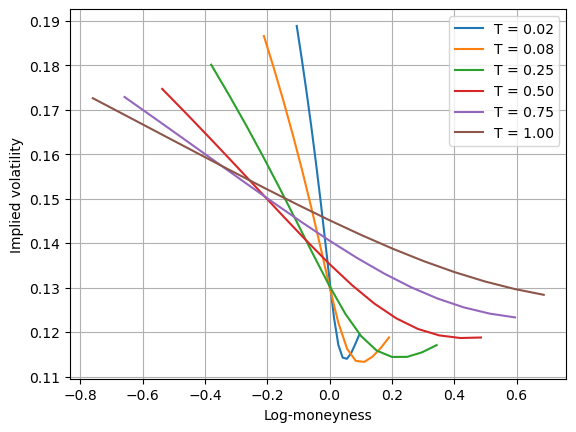

In [11]:
maturities = np.array( [1/52, 4/52, 0.25, 0.5, 0.75, 1.] ) # one week, one month, 3, 6, 9, 12 months

plot_vol_surface(maturities, X_hest, S0=S0, V0=V0)

## ATM skew

In order to calculate the ATM skew, we use finite difference method. By defult, strike is bumped by 5%:

$$
\psi(T) = \left| \dfrac{\partial\sigma_{\mathrm{IV}}(T, k)}{\partial k}\right|_{k=0} \approx \dfrac{\sigma_{\mathrm{IV}}(T, \log(1 + \epsilon)) - \sigma_{\mathrm{IV}}(T, \log(1 - \epsilon))}{\log(1 + \epsilon) - \log(1 - \epsilon)}
$$
with $\epsilon = 0.05$ the was chosen as a more numerically stable value.

In [12]:
def plot_atm_skew(maturities, models, S0, V0, bump=0.05, ls='-', ax=None, labels=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        
    strikes = np.array([1 - bump, 1 + bump]) * S0
    log_moneyness = np.log(strikes / S0)
    
    models = [models] if type(models) != list else models
    if labels is None:
        labels = ['ATM skew'] * len(models)
    for model, label in zip(models, labels):
        atm_skew = np.zeros_like(maturities)
        for i, T in tqdm(enumerate(maturities)):
            call_prices = [model.call(T=T, K=K, S=S0, V=V0) for K in strikes]
            iv = black_iv(option_price=call_prices, T=T, K=strikes, F=S0, r=r, flag='c')
            atm_skew[i] = (iv[1] - iv[0]) / (log_moneyness[1] - log_moneyness[0])

        lr = LinearRegression()
        idx = maturities < 0.1
        lr.fit(np.log(maturities[idx])[:, None], np.log(np.abs(atm_skew[idx])))
        ax[0].plot(maturities, np.abs(atm_skew), label=label, ls=ls)
        ax[1].loglog(maturities, np.abs(atm_skew), 'o', ms=4, label=label + f', short-end slope={np.round(lr.coef_[0], 2)}', ls=ls)
    ax[0].grid()
    ax[0].legend()
    ax[0].set_xlabel('Maturity')
    ax[0].set_ylabel('ATM skew')
    ax[0].set_title('ATM skew')
    
    ax[1].grid()
    ax[1].legend()
    ax[1].set_xlabel('Maturity (log)')
    ax[1].set_ylabel('ATM skew (log)')
    ax[1].set_title('ATM skew, loglog')

In [13]:
theta = 0.0398*1.5768
rho = -0.5711

S0 = 1
V0 = 0.0175

In [14]:
maturities = np.linspace(0.01, 1, 50)

eps_grid = [1, 0.1, 0.0001, 0.00001, 1e-7]
models = [Heston_model(theta=theta, kappa=1 / eps, eta=1 / eps, rho=rho) for eps in eps_grid]
labels = [f'eps = {eps}' for eps in eps_grid]

50it [00:00, 65.67it/s]
50it [00:01, 26.88it/s]
50it [00:04, 10.91it/s]
50it [00:05,  8.71it/s]
50it [00:04, 11.20it/s]


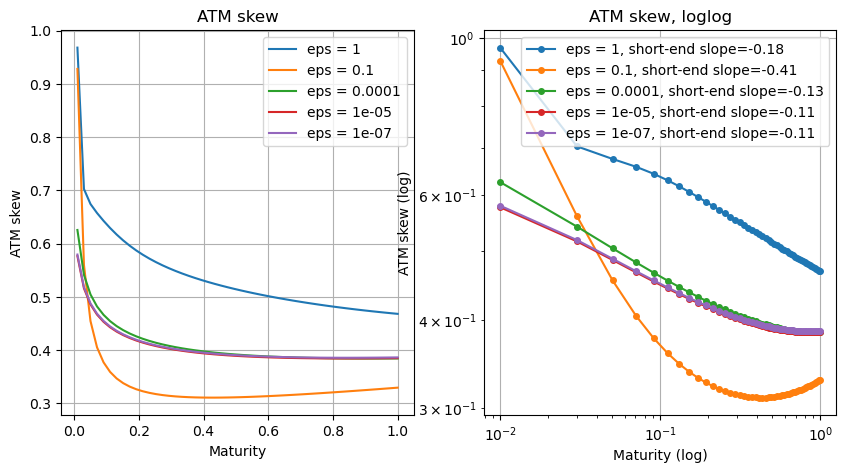

In [17]:
plot_atm_skew(maturities, models, S0=S0, V0=V0, labels=labels, bump=0.05)

### Conclusion

- For $\epsilon \to 0$, the behavior of the ATM skew tends to the power low at the short end.
- However, the estimated slope and the short end ($T < 0.1$) in log-log is around $-0.11$ that is way much greater than observed in practice (around $-0.4$ according to the example in "Volatility is rough")

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">2. Volterra Heston</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong>  </strong></p>

1. Do the same thing for Volterra Heston model:
Heston by a fractional one:
\begin{align*}
	dS_t &= S_t \sqrt{V_t} dB_t, \quad S_0=1,\\
	V_t &= V_0 + \int_0^t   K_{\epsilon}(t-s) \left(  ( \theta - \kappa V_s) ds +  \eta  \sqrt{V_s} dW_s \right),
\end{align*}
with $K_{\epsilon}(t) = {{(t +\epsilon)}^{H-1/2}}$

by implementing the Adam Scheme (or any other scheme) for the Riccati Volterra equation

2.  Plot the volatility surface for with $T=\{0.02, 0.04, 0.1, 0.25, 0.5, 1. \}$
and parameters 
\begin{equation} \label{eq:roughHestonParams}
 \kappa = 0, \quad    \rho=-0.7, \quad \theta=0.02, \quad \eta=0.3, \quad V_0=0.02, \quad H=0.1.
\end{equation}

3. For fixed $\epsilon =0$, make $H$ vary and plot the atm-skew between 1 week and 1 year for varying $H$ and comment
4. For fixed $H=0.01$ make $\epsilon$ vary and plot the atm-skew between 1 week and 1 year  and comment. 
5. Which model seems more suited for the market? argue. 
 

### Pricing via characteristic function

The characteristic function in the Volterra model
$$
\mathbb{E}\left[e^{i\log S_T}\right] = \exp\left\{ u \log S_0 + \int_0^T F(\psi)(T - s)g_0(s)\, ds \right\},
$$
where
$$
g_0(t) = V_0 + \int_0^t K_\epsilon(t-s)\theta\, ds = V_0 + \dfrac{\theta}{\Gamma\left(H + \frac32 \right)}\left[(t + \epsilon)^{H+\frac12} - \epsilon^{H + \frac12}\right].
$$
and $\psi$ is a solution to the Volterra Riccati equation:
$$
\psi(t) =  \int_0^t K_\epsilon(t - s)F(\psi(s))\, ds,
$$
with
$$
F(\psi) = \dfrac12(u^2 - u) + (u\rho\eta - \lambda)\psi + \dfrac{\eta^2}{2}\psi^2.
$$
For a fixed T, the function $\psi$ is calculated on the uniform grid $\{t_k\}_{k=0}^{N}$ with step $\Delta$ by the fractional Adams method (described below), and the integral in the characteristic function is approximated according to the trapezoidal rule. 

## Adams scheme
We adopt the Adams scheme described in the article "The characteristic function of rough Heston models" for the rough Riccati equation ($\epsilon = 0$) for the case of shifted kernel.

Given the function $\psi$ on $\{t_j\}_{j=0}^k$ (initially $\psi(0) = 0$), we aim to compute $\psi(t_{k+1})$. The following predictor-corrector scheme is used:
$$
\psi^P(t_{k+1}) = \sum_{j=0}^k b_{j, k+1}F(\psi(t_j)), \\
\psi(t_{k+1}) = \sum_{j=0}^k a_{j, k+1}F(\psi(t_j)) + a_{k+1, k+1}F(\psi^P(t_{k+1})).
$$
Here the expression for the predictor comes from the rectangular approximation of the integral in the Riccati equation, and the final formula is a result of the trapezoidal rule applied to this integral. The coefficients for the shifted fractional kernel are given by
$$
b_{j, k+1} = \dfrac{1}{\Gamma\left(H+\frac32\right)}\left[(t_{k+1} - t_j + \epsilon)^{H+\frac12} - (t_{k+1} - t_{j+1} + \epsilon)^{H+\frac12}\right], \quad j = 0, \ldots, k, \\
a_{0, k+1} = \dfrac{1}{\Delta \Gamma\left(H+\frac52\right)}\left[ \Delta\left(H + \dfrac32\right)(t_{k+1} + \epsilon)^{H+\frac12}  + (t_{k+1} - t_1 + \epsilon)^{H + \frac32} - (t_{k+1} + \epsilon)^{H + \frac32} \right], \\
a_{j, k+1} = \dfrac{1}{\Delta \Gamma\left(H+\frac52\right)}\left[(t_{k+1} - t_{j - 1} + \epsilon)^{H+\frac32}  + (t_{k+1} - t_{j+1} + \epsilon)^{H + \frac32} - 2(t_{k+1} - t_j + \epsilon)^{H + \frac32} \right], \quad j = 1, \ldots, k, \\
a_{k+1, k+1} = \dfrac{1}{\Delta \Gamma\left(H+\frac52\right)}\left[ -\Delta\left(H + \dfrac32\right)\epsilon^{H+\frac12}  + (\Delta + \epsilon)^{H + \frac32} - \epsilon^{H + \frac32} \right].
$$

In [18]:
@dataclass
class VolterraHeston_model(CF_model):
    theta: float
    kappa: float
    rho: float
    eta: float
    H: float
    eps: float
    
    def __F(self, u, psi):
        return 0.5 * (u**2 - u) + (u * self.rho * self.eta - self.kappa) * psi + 0.5 * (self.eta * psi)**2
    
    def __g0(self, t, V0):
        return V0 + self.theta / gamma(self.H + 1.5) * ((t + self.eps)**(H + 0.5) - self.eps**(H + 0.5))
    
    def __b_coefs(self, t_grid, k):
        b_k = 1 / gamma(self.H + 1.5) * ((t_grid[k + 1] - t_grid[:k + 1] + self.eps)**(self.H + 0.5) - 
                                         (t_grid[k + 1] - t_grid[1:k + 2] + self.eps)**(self.H + 0.5))
        return b_k
    
    def __a_coefs(self, t_grid, k):
        dt = t_grid[1] - t_grid[0]
        a_k = np.zeros(k + 1)
        a_k[0] = 1 / dt / gamma(H + 2.5) * (dt * (H + 1.5) * (t_grid[k + 1] + self.eps)**(self.H + 0.5) +
                                            (t_grid[k + 1] - dt + self.eps)**(H + 1.5) - 
                                            (t_grid[k + 1] + self.eps)**(H + 1.5))
        a_k[1:] = 1 / dt / gamma(H + 2.5) * ((t_grid[k + 1] - t_grid[:k] + self.eps)**(H + 1.5) +
                                             (t_grid[k + 1] - t_grid[2:k + 2] + self.eps)**(H + 1.5) -
                                             2 * (t_grid[k + 1] - t_grid[1:k + 1] + self.eps)**(H + 1.5))
        a_k_last = 1 / dt / gamma(H + 2.5) * (-dt * (H + 1.5) * self.eps**(self.H + 0.5) + 
                                              (dt + self.eps)**(H + 1.5) - self.eps**(H + 1.5))
        return a_k, a_k_last
    
    def __psi_on_grid(self, t_grid, u):
        psi = np.zeros_like(t_grid, dtype=complex)
        F = np.zeros_like(t_grid, dtype=complex)
        for k in range(len(psi) - 1):
            F[k] = self.__F(u, psi[k])
            
            b_k = self.__b_coefs(t_grid, k)
            psi_pred = b_k @ F[:k + 1]
            
            a_k, a_k_last = self.__a_coefs(t_grid, k)
            psi[k + 1] = a_k @ F[:k + 1] + a_k_last * self.__F(u, psi_pred)
        return psi
        
    def _charfunc(self, v, T, S0, V0):
        u = 1j * v
        DELTA_MAX = 1 / 1000
        
        n_grid = ceil(T / DELTA_MAX)
        t_grid = np.linspace(0, T, n_grid)
        dt = t_grid[1] - t_grid[0]
        psi = self.__psi_on_grid(t_grid, u)
        F = self.__F(u, psi)
        g0 = self.__g0(t_grid, V0)
        res = np.exp(u * np.log(S0) + np.trapz(np.flip(F) * g0, x=t_grid)) # dt * np.flip(F[1:]) @ g0[:-1]) # 
        if np.isnan(res) or np.isinf(res) or np.abs(res) > 1:
            return 0
        return res

## Sanity check

We show that the characteristic function of Volterra Heston coincides with the one of standard Heston with the same parameters when $H = 0.5$ and $\epsilon = 0$.

In [19]:
kappa = 0
theta = 0.02
rho = -0.7
eta = 0.3

H = 0.5
eps = 0.00

S0 = 1.
V0 = 0.02

volterra_model = VolterraHeston_model(theta=theta, kappa=kappa, rho=rho, eta=eta, H=H, eps=eps)
heston_model = Heston_model(theta=theta, kappa=kappa, rho=rho, eta=eta)

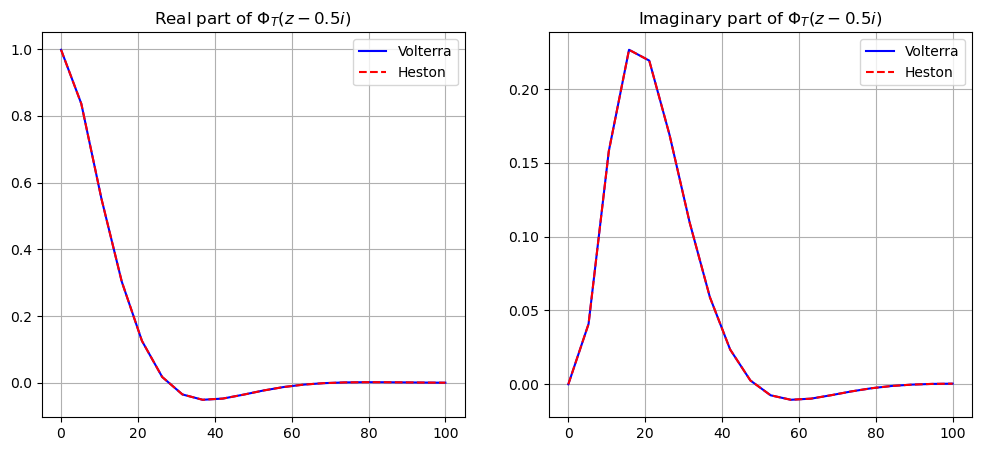

In [20]:
v_array = np.linspace(0, 100, 20) - 0.5j
cf_volterra = [volterra_model._charfunc(v, T=T, S0=S0, V0=V0) for v in v_array]
cf_heston = [heston_model._charfunc(v, T=T, St=S0, Vt=V0) for v in v_array]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(np.real(v_array), np.real(cf_volterra), 'b', label='Volterra')
ax[0].plot(np.real(v_array), np.real(cf_heston), 'r--', label='Heston')
ax[0].legend()
ax[0].grid()
ax[0].set_title("Real part of $\Phi_T(z - 0.5i)$")

ax[1].plot(np.real(v_array), np.imag(cf_volterra), 'b', label='Volterra')
ax[1].plot(np.real(v_array), np.imag(cf_heston), 'r--', label='Heston')
ax[1].legend()
ax[1].grid()
ax[1].set_title("Imaginary part of $\Phi_T(z - 0.5i)$")

plt.show()

In [21]:
K = 1
T = 1

print('Call price, Heston:', heston_model.call(T=T, K=K, S=S0, V=V0))
print('Call price, Volterra Heston:', volterra_model.call(T=T, K=K, S=S0, V=V0))

Call price, Heston: 0.06090947172832506
Call price, Volterra Heston: 0.06090946006390707


## Implied volatility surface

In [22]:
kappa = 0
theta = 0.02
rho = -0.7
eta = 0.3

H = 0.1
eps = 0.00

S0 = 1.
V0 = 0.02

volterra_model = VolterraHeston_model(theta=theta, kappa=kappa, rho=rho, eta=eta, H=H, eps=eps)

100%|██████████| 15/15 [05:20<00:00, 21.40s/it]


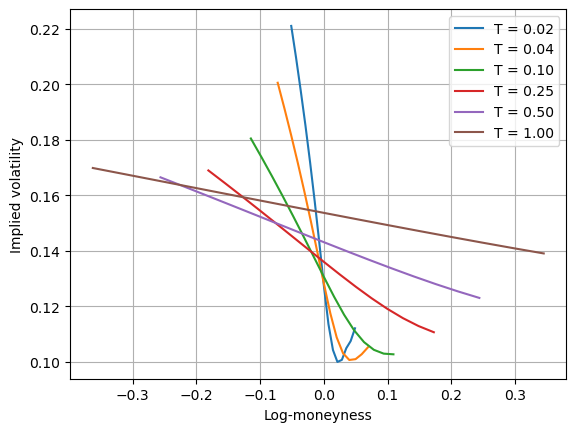

In [23]:
maturities = np.array([0.02, 0.04, 0.1, 0.25, 0.5, 1.])

plot_vol_surface(maturities, volterra_model, S0=S0, V0=V0, strike_range=(0.95, 1.05))

## ATM skew for rough Heston ($\epsilon = 0$)

In [24]:
kappa = 0
theta = 0.02
rho = -0.7
eta = 0.3

eps = 0

S0 = 1.
V0 = 0.02

In [25]:
maturities = np.linspace(0.02, 1, 20)

H_grid = [0.01, 0.1, 0.25, 0.5]
models = [VolterraHeston_model(theta=theta, kappa=kappa, eta=eta, rho=rho, H=H, eps=eps) for H in H_grid]
labels = [f'H = {H}' for H in H_grid]

In [ ]:
plot_atm_skew(maturities, models, S0=S0, V0=V0, labels=labels, bump=0.01)

20it [18:45, 56.30s/it] 
1it [00:01,  1.19s/it]

## ATM skew for $H = 0.01$

In [ ]:
kappa = 0
theta = 0.02
rho = -0.7
eta = 0.3

H = 0.01

S0 = 1.
V0 = 0.02

In [ ]:
maturities = np.linspace(0.02, 1, 20)

eps_grid = [0.000, 0.01, 0.05, 0.1, 0.5]
models = [VolterraHeston_model(theta=theta, kappa=kappa, eta=eta, rho=rho, H=H, eps=eps) for eps in eps_grid]
labels = [f'eps = {eps}' for eps in eps_grid]

In [ ]:
plot_atm_skew(maturities, models, S0=S0, V0=V0, labels=labels, bump=0.01)

Which model seems more suited for the market? argue. 

### Conlusions

- As it was seen in the cours, a desirable value of the ATM skew slope at the short end should be around $-0.32$.

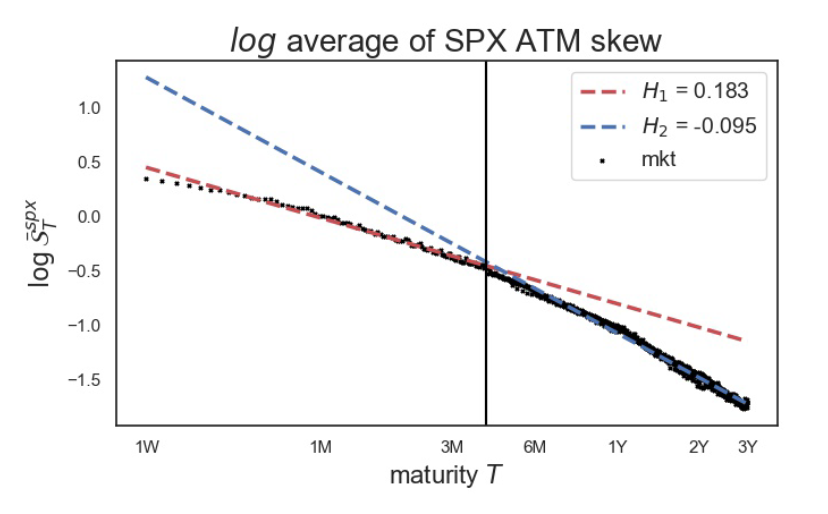